In [1]:
import os
import argparse
import json
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers
from transformers import AutoModelForTokenClassification, AutoTokenizer

# set TOKENIZERS_PARALLELISM so that it doesn't annoy us
os.environ["TOKENIZERS_PARALLELISM"] = "false"
def parse_arguments():
    parser = argparse.ArgumentParser(description='Train a model on the SNLI dataset')
    parser.add_argument('--model', type=str, default='/fp/homes01/u01/ec-rasyed/2024/labs/06/mand2/bert-base-multilingual-cased', help='The model to use')
    parser.add_argument('--batch_size', type=int, default=32, help='The batch size')
    parser.add_argument('--epochs', type=int, default=2, help='The number of epochs to train')
    parser.add_argument('--lr', type=float, default=1e-4, help='The learning rate')
    parser.add_argument('--seed', type=int, default=42, help='The random seed')
    parser.add_argument('--warmup_steps', type=int, default=50, help='The number of warmup steps')
    parser.add_argument('--gradient_clipping', type=float, default=10.0, help='The gradient clipping value')
    return parser.parse_args([])

args = parse_arguments()

# set random seed
torch.manual_seed(args.seed)

# set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# load tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    args.model,
    cache_dir="./cache"
)

cuda:0


In [2]:
import os
import pandas as pd
from nltk.tokenize import sent_tokenize
from operator import itemgetter
from sklearn.preprocessing import LabelEncoder
import itertools
from itertools import chain
from datasets import Dataset
from transformers import AutoTokenizer
import numpy as np
from sklearn.model_selection import train_test_split

class datacollector:
    def __init__(self, name_of_file):
        self.name_of_file = name_of_file

    def __call__(self,train:bool):
        if not isinstance(train, bool):
            raise TypeError("train parameter must be a boolean")
            
        current_directory = os.getcwd()
        paths_to_print = self.import_func([self.name_of_file], current_directory)
        print(paths_to_print)
        doc = self.read_file_to_df(paths_to_print)[0]

        train_text_col = doc.iloc[:, 0].to_string(index=False)
        train_text = ' '.join(train_text_col.split())

        sent_tokenizing = sent_tokenize(train_text)

        train_lab_col = doc.iloc[:, 1].to_string(index=False)
        train_labels = ' '.join(train_lab_col.split())

        train_text_list = train_text_col.split()
        train_label_list = train_lab_col.split()
        text_sent,label_sent=self.tokenize_text_and_labels(train_text_list, train_label_list)
 
        self.all_labels = list(itertools.chain.from_iterable(label_sent))
        label_encoder = LabelEncoder()
        label_encoder.fit(self.all_labels)
        
        numerical_NER = [list(label_encoder.transform(sublist_list)) for sublist_list in label_sent]
       

        numeric_flatt_unique=list(np.unique(np.array(list(chain.from_iterable(numerical_NER)))))
        all_labels_flatt_unique=list(np.unique(np.array(self.all_labels)))
 
        data = {"tokens": text_sent, "ner_tags": numerical_NER}
        # Create a dataset from the Pandas DataFrame
        data = Dataset.from_dict(data)

        tokenized_data = data.map(self.tokenize_and_adjust_labels, batched=True)
        if train==True:
             
            text_sent_train,text_sent_val,train_label,val_label=train_test_split(text_sent, label_sent,test_size=0.2)

            train_numerical_NER=self.numeric_target(train_label)
            val_numerical_NER=self.numeric_target(val_label)
           
            data_train=data = {"tokens": text_sent_train, "ner_tags": train_numerical_NER[0]}
            data_train = Dataset.from_dict(data_train)
            data_val = {"tokens": text_sent_val, "ner_tags": val_numerical_NER[0]}
            data_val = Dataset.from_dict(data_val)
            tokenized_train_data=data_train.map(self.tokenize_and_adjust_labels, batched=True)
            tokenized_eval_data=data_val.map(self.tokenize_and_adjust_labels, batched=True)
            return tokenized_train_data,tokenized_eval_data,train_numerical_NER[1],val_numerical_NER[1]
        return tokenized_data,all_labels_flatt_unique
    
    def numeric_target(self,labels):
        all_labels = list(itertools.chain.from_iterable(labels))
        label_encoder = LabelEncoder()
        label_encoder.fit(all_labels)
        
        numerical_NER = [list(label_encoder.transform(sublist_list)) for sublist_list in labels]
       

        numeric_flatt_unique=list(np.unique(np.array(list(chain.from_iterable(numerical_NER)))))
        all_labels_flatt_unique=list(np.unique(np.array(all_labels)))
        return numerical_NER,all_labels_flatt_unique
    
    def find_substring_index(self, substring_list, string_list):
        indexes = []
        for substring in substring_list:
            try:
                index = next(i for i, string in enumerate(string_list) if substring in string)
                indexes.append(index)
            except StopIteration:
                indexes.append(-1)
        return indexes

    def import_func(self, sub_string_list, current_dir):
        dir_path = current_dir

        # Construct the base path for the data directory
        dir_path = os.path.join(dir_path, "data")

        files = os.listdir(dir_path)

        list_paths = [os.path.join(dir_path, files[i]) for i in range(len(files))]
        match_on = self.find_substring_index(sub_string_list, list_paths)

        path_get = itemgetter(*match_on)
        get_paths = path_get(list_paths)
        return get_paths

    def read_file_to_df(self, path_in_list):
        if not path_in_list:
            return []
        
        df_list = []
        path_in_list=[path_in_list]
        for path_in in path_in_list:
            
            with open(path_in, "rb") as f:
                
                df = pd.read_csv(f.name, sep="\t", header=0)
                df_list.append(df)
            
        return df_list

    def tokenize_text_and_labels(self,text_list, labels_list):
        """
        Tokenize the input text into sentences and preserve the one-to-one correspondence
        between tokens and labels.
    
        Args:
        - text (str): The input text to tokenize.
        - labels (str): The corresponding labels for each word in the text.
    
        Returns:
        - tokenized_texts (list): The tokenized sentences.
        - tokenized_labels (list): The corresponding labels for each token.
        """
    
    
        # Initialize lists to store tokenized text and labels
        tokenize_nested_text=[]
        tokenize_nested_label=[]
        tokenized_texts = []
        tokenized_labels = [] 
        # Keep track of the current index in the tokenized text
        current_index = 0
        len_text_list=len(text_list)
        count_for=0
        # Iterate through sentences
        for i,word in enumerate(text_list):
            count_for+=1
            
                
            
            if current_index<=10:
                
                tokenized_texts.append(word)
                
                if ("," in word or "." in word) and len(word)==1:
                   
                # Append the corresponding label to the tokenized labels
                   tokenized_labels.append("O")
                   current_index=current_index 
                else:
                    tokenized_labels.append(labels_list[i])
                    current_index+=1
                
            if current_index>10:
                current_index=0
                tokenized_texts = []
                tokenized_labels = [] 
            
            if current_index==10:
                tokenize_nested_text.append(tokenized_texts)
                tokenize_nested_label.append(tokenized_labels)
            
            if count_for==len_text_list:
               break
           
            
        return tokenize_nested_text, tokenize_nested_label

    def tokenize_and_adjust_labels(self,samples_per_split):
      tokenized_samples = tokenizer.batch_encode_plus(samples_per_split["tokens"],return_tensors='pt', padding=True, truncation=True ,is_split_into_words=True)
     
      adjusted_labels = []
      print(len(tokenized_samples["input_ids"]))
      for k in range(0, len(tokenized_samples["input_ids"])):
        prev_wid = -1
        word_ids_list = tokenized_samples.word_ids(batch_index=k)
        existing_label_ids = samples_per_split["ner_tags"][k]
      
          
        j = -1
        adjusted_label_ids = []
       
        for wid in word_ids_list:
          if(wid is None):
            adjusted_label_ids.append(-100)
          elif(wid!=prev_wid):
            j = j + 1
            adjusted_label_ids.append(existing_label_ids[j])
            prev_wid = wid
          else:
            label_name = self.all_labels[existing_label_ids[j]]
            adjusted_label_ids.append(existing_label_ids[j])
            
        adjusted_labels.append(adjusted_label_ids)
      tokenized_samples["labels"] = adjusted_labels
      return tokenized_samples


#data_collector = datacollector("train-en.tsv.gz")


#train_set=data_collector(train=True)






In [3]:
from itertools import chain
from torch.nn.utils.rnn import pad_sequence

class util_Dataset(torch.utils.data.Dataset):
    def __init__(self, data, label_vocab=None):


        self.data=data

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return len(self.data)


class CollateFunctor:
    def __init__(self, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __call__(self, batch):
        input_ids = []
        token_type_ids = []
        attention_mask = []
        labels = []
        
        # Iterate over each sample in the batch
        for sample in batch:
            # Pad or truncate input_ids, token_type_ids, attention_mask
            input_ids.append(torch.tensor(sample["input_ids"]))
            token_type_ids.append(torch.tensor(sample["token_type_ids"]))
            attention_mask.append(torch.tensor(sample["attention_mask"]))
            # Add padding to labels
           
            labels.append(torch.tensor(sample["labels"] +  (len( input_ids)-len(sample["labels"]))*[-100] ))
        
        # Pad sequences to ensure uniform length
        input_ids = pad_sequence(input_ids, batch_first=True, padding_value=self.tokenizer.pad_token_id)
        token_type_ids = pad_sequence(token_type_ids, batch_first=True, padding_value=0,)
        attention_mask = pad_sequence(attention_mask, batch_first=True, padding_value=0)
        labels = pad_sequence(labels, batch_first=True, padding_value=-100)
        labels=torch.stack([term.squeeze(0) for term in labels])
        inputs = {
            "input_ids": input_ids,
            "token_type_ids": token_type_ids,
            "attention_mask": attention_mask,
            "labels": labels
        }
        #print(inputs)
        #print(self.tokenizer.pad_token_id)
        #inputs['labels'] = torch.tensor(labels)
         
        return inputs

In [4]:
#train_set = util_Dataset(train_set)

data_collector_train_val = datacollector("train-en.tsv.gz")
train_set,val_set,label_unique_train,label_unique_val=data_collector_train_val(train=True)
train_set = util_Dataset(train_set)
val_set = util_Dataset(val_set)

data_collector_test = datacollector("dev-en.tsv.gz")
test_set,label_unique_test=data_collector_test(train=False)
test_set = util_Dataset(test_set)

train_loader = torch.utils.data.DataLoader(
train_set, batch_size=args.batch_size, shuffle=True, drop_last=True,
collate_fn=CollateFunctor(tokenizer, 40)
)

val_loader = torch.utils.data.DataLoader(
val_set, batch_size=args.batch_size, shuffle=True, drop_last=True,
collate_fn=CollateFunctor(tokenizer, 40)
)

test_loader = torch.utils.data.DataLoader(
test_set, batch_size=args.batch_size, shuffle=True, drop_last=True,
collate_fn=CollateFunctor(tokenizer, 40)
)
# Peek at the first batch
for batch in train_loader:
    for key, value in batch.items():
        print(f"{key}:\t{value.shape}\t{value.dtype}")
    break	


print("Input subwords: ", end="")
for subword_id in batch['input_ids'][0]:
    print('`' + tokenizer.decode(subword_id.item()) + '`', end=" ")

/fp/homes01/u01/ec-rasyed/2024/labs/06/mand2/assignment2/IN5550-mandatory-2/data/train-en.tsv.gz


Map:   0%|          | 0/14518 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
518


Map:   0%|          | 0/11614 [00:00<?, ? examples/s]

1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
614


Map:   0%|          | 0/2904 [00:00<?, ? examples/s]

1000
1000
904
/fp/homes01/u01/ec-rasyed/2024/labs/06/mand2/assignment2/IN5550-mandatory-2/data/dev-en.tsv.gz


Map:   0%|          | 0/7334 [00:00<?, ? examples/s]

1000
1000
1000
1000
1000
1000
1000
334
input_ids:	torch.Size([32, 48])	torch.int64
token_type_ids:	torch.Size([32, 48])	torch.int64
attention_mask:	torch.Size([32, 48])	torch.int64
labels:	torch.Size([32, 48])	torch.int64
Input subwords: 

2024-03-06 22:30:11.242194: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-06 22:30:11.242255: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-06 22:30:11.243287: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-06 22:30:11.249740: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-06 22:30:15.045010: W tensorflow/compiler/tf2

`[CLS]` `Sf` `##ânt` `##u` `Gheorghe` `[UNK]` `B` `##ă` `##ile` `Tu` `##ș` `##nad` `[UNK]` `Mi` `##er` `##cure` `##a` `-` `Ci` `##uc` `[UNK]` `Top` `##li` `##ța` `IS` `##U` `JG` `##P` `[SEP]` `[PAD]` `[PAD]` `[PAD]` `[PAD]` `[PAD]` `[PAD]` `[PAD]` `[PAD]` `[PAD]` `[PAD]` `[PAD]` `[PAD]` `[PAD]` `[PAD]` `[PAD]` `[PAD]` `[PAD]` `[PAD]` `[PAD]` 

In [5]:
from transformers import  TrainingArguments, Trainer
import numpy as np
from datasets import load_metric
from seqeval.metrics import classification_report

model = AutoModelForTokenClassification.from_pretrained(
    args.model,
    cache_dir="./cache",
    trust_remote_code=True,
    num_labels=7
)
item_list=[]
def train_epoch(model, train_loader, optimizer, lr_scheduler, device):
    model.train()
    progress_bar = tqdm(train_loader, desc="Training")
    for batch in progress_bar:
        #batch = batch.to(device)
        #.to(device)
        optimizer.zero_grad()
        #print(batch["labels"])
        # forward pass
        model_out = model(**batch)
        #print(model_out.logits)
        
        
        loss = model_out.loss
        
        # backward pass
        loss.backward()

        # update weights
        lr_scheduler.step()
        optimizer.step()

        progress_bar.set_postfix(loss=loss.item(), lr=optimizer.param_groups[0]['lr'])

        item_list.append(loss.item())

@torch.no_grad()
def compute_metrics(model,data,all_labels_flatt_unique):
    
    all_predictions = []
    all_labels = []
    model.eval()
    total_correct, total_samples = 0, 0
    for batch in tqdm(data):
        #batch = batch.to(device)
        #.to(device)
        outputs = model(**batch)
        predictions=outputs.logits
        labels=batch["labels"]
        predictions = np.argmax(predictions, axis=2)

        filtered_predictions = []
        filtered_labels = []
        for pred_seq, label_seq in zip(predictions, labels):
            pred_seq_filtered = []
            label_seq_filtered = []
            for pred, label in zip(pred_seq, label_seq):
                if label != -100:
                    pred_seq_filtered.append(pred)
                    label_seq_filtered.append(label)
            filtered_predictions.append(pred_seq_filtered)
            filtered_labels.append(label_seq_filtered)

           
        for pred_seq, label_seq in zip(filtered_predictions, filtered_labels):
            pred_labels = [all_labels_flatt_unique[pred] for pred in pred_seq]
            true_labels = [all_labels_flatt_unique[label] for label in label_seq]
            all_predictions.append(pred_labels)
            all_labels.append(true_labels)

    # Compute evaluation metrics
    report = classification_report(all_labels, all_predictions,output_dict=True)
    #print(all_labels[1:100])
   # print(all_predictions[1:100])
    return report





/fp/projects01/ec30/software/easybuild/software/nlpl-pytorch/2.1.2-foss-2022b-cuda-12.0.0-Python-3.10.8/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of BertForTokenClassification were not initialized from the model checkpoint at /fp/homes01/u01/ec-rasyed/2024/labs/06/mand2/bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
from transformers import  TrainingArguments, Trainer
import numpy as np
from datasets import load_metric
from seqeval.metrics import classification_report

model = AutoModelForTokenClassification.from_pretrained(
    args.model,
    cache_dir="./cache",
    trust_remote_code=True,
    num_labels=7
).to(device)
loss_list=[]
def train_epoch(model, train_loader, optimizer, lr_scheduler, device):
    model.train()
    progress_bar = tqdm(train_loader, desc="Training")
    
    for batch in progress_bar:
        #batch = batch.to(device)
        inputs = {key: value.to(device) for key, value in batch.items()}
        #inputs=batch
        #.to(device)
        optimizer.zero_grad()
        #print(batch["labels"])
        # forward pass
        
        model_out = model(**inputs)
        #print(model_out.logits)
        
        
        loss = model_out.loss
        
        # backward pass
        loss.backward()

        # update weights
        lr_scheduler.step()
        optimizer.step()

        progress_bar.set_postfix(loss=loss.item(), lr=optimizer.param_groups[0]['lr'])
        loss_list.append(loss.item())
 

@torch.no_grad()
def compute_metrics(model,data,all_labels_flatt_unique):
    
    all_predictions = []
    all_labels = []
    model.eval()
    total_correct, total_samples = 0, 0
    for batch in tqdm(data):
        inputs = {key: value.to(device) for key, value in batch.items()}
        #.to(device)
        #inputs=batch
        outputs = model(**inputs)
        predictions=outputs.logits.to("cpu")
        #predictions=predictions.detach()

        labels=batch["labels"]
        #print(labels)
        predictions = np.argmax(predictions, axis=2)
        #print(predictions)
     
        filtered_predictions = []
        filtered_labels = []
        for pred_seq, label_seq in zip(predictions, labels):
            pred_seq_filtered = []
            label_seq_filtered = []
            for pred, label in zip(pred_seq, label_seq):
                if label != -100:
                    pred_seq_filtered.append(pred)
                    label_seq_filtered.append(label)
            filtered_predictions.append(pred_seq_filtered)
            filtered_labels.append(label_seq_filtered)

           
        for pred_seq, label_seq in zip(filtered_predictions, filtered_labels):
            pred_labels = [all_labels_flatt_unique[pred] for pred in pred_seq]
            true_labels = [all_labels_flatt_unique[label] for label in label_seq]
            all_predictions.append(pred_labels)
            all_labels.append(true_labels)

    # Compute evaluation metrics
    report = classification_report(all_labels, all_predictions,output_dict=True)
    #print(all_labels[1:100])
   # print(all_predictions[1:100])
    return report




Some weights of BertForTokenClassification were not initialized from the model checkpoint at /fp/homes01/u01/ec-rasyed/2024/labs/06/mand2/bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
optimizer = torch.optim.AdamW(
    model.parameters(), lr=args.lr
)
lr_scheduler = transformers.get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=args.warmup_steps, num_training_steps=len(train_loader) * args.epochs
)

f1_micro_avg=[]
f1_macro_avg=[]
f1_weighted_avg=[]
for epoch in range(args.epochs):
    train_epoch(model, train_loader, optimizer, lr_scheduler, device)
    eval_metric_val=compute_metrics(model,val_loader,label_unique_val)
    f1_micro_avg.append(eval_metric_val["micro avg"]['f1-score'])
    f1_macro_avg.append(eval_metric_val["macro avg"]['f1-score'])
    f1_weighted_avg.append(eval_metric_val["weighted avg"]['f1-score'])
    print(eval_metric_val)
    


100%|██████████| 90/90 [00:03<00:00, 29.53it/s]


{'LOC': {'precision': 0.8031014078759436, 'recall': 0.8665785997357992, 'f1-score': 0.8336333792227046, 'support': 4542}, 'ORG': {'precision': 0.675097862089732, 'recall': 0.6142465753424657, 'f1-score': 0.6432362645244584, 'support': 3650}, 'PER': {'precision': 0.8140262993112085, 'recall': 0.8248730964467005, 'f1-score': 0.8194138039710054, 'support': 3152}, 'micro avg': {'precision': 0.7689208128941836, 'recall': 0.7738011283497884, 'f1-score': 0.771353251318102, 'support': 11344}, 'macro avg': {'precision': 0.7640751897589614, 'recall': 0.7685660905083219, 'f1-score': 0.765427815906056, 'support': 11344}, 'weighted avg': {'precision': 0.764951047834008, 'recall': 0.7738011283497884, 'f1-score': 0.7684209700335336, 'support': 11344}}


100%|██████████| 90/90 [00:03<00:00, 29.49it/s]


{'LOC': {'precision': 0.8380266779589244, 'recall': 0.873923603444469, 'f1-score': 0.8555987894509295, 'support': 4529}, 'ORG': {'precision': 0.7057268722466961, 'recall': 0.6639955788891959, 'f1-score': 0.6842255125284737, 'support': 3619}, 'PER': {'precision': 0.8124072425051945, 'recall': 0.8683375634517766, 'f1-score': 0.8394418034043858, 'support': 3152}, 'micro avg': {'precision': 0.7913368704879534, 'recall': 0.8051327433628318, 'f1-score': 0.7981751984910296, 'support': 11300}, 'macro avg': {'precision': 0.7853869309036049, 'recall': 0.8020855819284805, 'f1-score': 0.7930887017945963, 'support': 11300}, 'weighted avg': {'precision': 0.7885093808418704, 'recall': 0.8051327433628318, 'f1-score': 0.7962070452738433, 'support': 11300}}


In [8]:

eval_metric_test=compute_metrics(model,test_loader,label_unique_test)
print(eval_metric_test)

100%|██████████| 229/229 [00:09<00:00, 25.20it/s]


{'LOC': {'precision': 0.8262187628021302, 'recall': 0.860629854058206, 'f1-score': 0.8430733216286264, 'support': 11717}, 'ORG': {'precision': 0.6806869961444094, 'recall': 0.6267885960193652, 'f1-score': 0.6526268623277697, 'support': 9295}, 'PER': {'precision': 0.8050065876152833, 'recall': 0.8535687071374143, 'f1-score': 0.8285767120754485, 'support': 7874}, 'micro avg': {'precision': 0.777350324597259, 'recall': 0.7834591151422835, 'f1-score': 0.7803927653925068, 'support': 28886}, 'macro avg': {'precision': 0.7706374488539409, 'recall': 0.7803290524049951, 'f1-score': 0.7747589653439482, 'support': 28886}, 'weighted avg': {'precision': 0.7736070326039461, 'recall': 0.7834591151422835, 'f1-score': 0.7778394317572982, 'support': 28886}}


' '

In [9]:
eval_metric_train=compute_metrics(model,train_loader,label_unique_test)
print(eval_metric_train)

100%|██████████| 362/362 [00:13<00:00, 26.37it/s]


{'LOC': {'precision': 0.9021499737808075, 'recall': 0.9384170621284024, 'f1-score': 0.9199262091276101, 'support': 18333}, 'ORG': {'precision': 0.8527209904981284, 'recall': 0.7965839553493377, 'f1-score': 0.8236971108716059, 'support': 14871}, 'PER': {'precision': 0.8963386727688787, 'recall': 0.9343988549618321, 'f1-score': 0.9149731371174958, 'support': 12576}, 'micro avg': {'precision': 0.8855921166869248, 'recall': 0.8912407164700743, 'f1-score': 0.8884074380525193, 'support': 45780}, 'macro avg': {'precision': 0.8837365456826048, 'recall': 0.8897999574798575, 'f1-score': 0.886198819038904, 'support': 45780}, 'weighted avg': {'precision': 0.8844972579240417, 'recall': 0.8912407164700743, 'f1-score': 0.8873068829204404, 'support': 45780}}


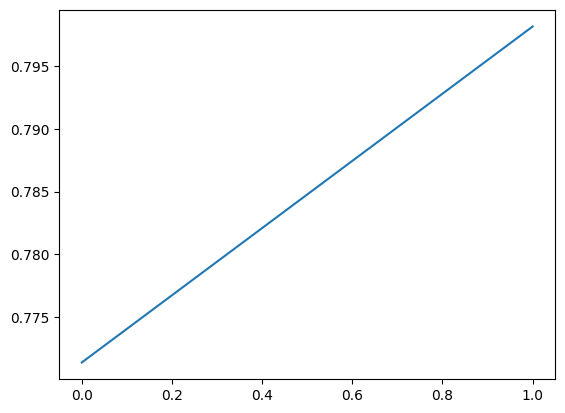

In [10]:
from matplotlib import pyplot as plt

plt.plot(range(0,len(f1_micro_avg)),f1_micro_avg)

In [10]:
#test classification_report function

from seqeval.metrics import classification_report

# Example nested lists of predictions and true labels
all_predictions = [['O', 'B-PER', 'I-PER', 'O'], ['B-LOC', 'I-LOC', 'O']]
all_labels = [['O', 'B-PER', 'I-PER', 'O'], ['B-LOC', 'I-LOC', 'O']]

# Compute classification report
report = classification_report(all_labels, all_predictions,output_dict=True)

# Print the report
report

{'LOC': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 1},
 'PER': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 1},
 'micro avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 2},
 'macro avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 2},
 'weighted avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 2}}